In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict
import time
import re

class KnapsackInstance:
    """
    Class to store knapsack probelm instance information.
    """

    def __init__(self, name: str, num_items: int, 
                 num_knapsacks: int, capacities: List[int], profits: List[int], 
                 weights: np.ndarray, optimal_value: int = None):
        """
        Initialize a knapsack instance.

        Args:
            name: Instance name/identifier
            num_items: Number of items (n)
            num_knapsacks: Nimer of kanpsacks 
            capacities: List of capacitycontraints for each knapsack 
            profits: Profit/value of each item
            weigths: Weight matrix 
            oprimal_value: Know optimal value
        """
        self.name = name
        self.num_items = num_items
        self.num_knapsacks = num_knapsacks
        self.capacities = capacities
        self.profits = profits
        self.weights = weights
        self.optimal_value = optimal_value

In [20]:
class DataLoader:
    """
    Handles loading of knapsack instances from different file formats.
    """

    def load_or_library(self, filepath, instance_names):
        """Load OR-Library instances from mknap2.txt file."""
        # Read the entire file content
        with open(filepath, 'r') as file:
            content = file.read()
        # Helper function to clean a line by removing comments and trimming whitespace
        def clean_line(line: str) -> str:
            if '//' in line:
                line = line[:line.index('//')]
            return line.strip()

        instances = []
        content_lower = content.lower()
        for name in instance_names:
            # Find the start of the instance block by name
            search_pattern = f"problem {name}.DAT"
            search_lower = search_pattern.lower()

            idx = content_lower.find(search_lower)
            if idx == -1:
                print(f"Warning: Instance {name} not found")
                continue
            # Fin the first line after the instance header
            start_pos = content.find('\n', idx)
            if start_pos == -1:
                print(f"Warning: Malformed block for {name}")
                continue
            start_pos += 1

            # Skip empty/comment/++++ lines to find the m n line
            while start_pos < len(content):
                line_end = content.find('\n', start_pos)
                if line_end == -1:
                    line_end = len(content)
                first_line = clean_line(content[start_pos:line_end])
                if first_line and not first_line.startswith('++++'):
                    break
                start_pos = line_end + 1
            # If no valid m n line found, skip this isinstance
            if not first_line:
                print(f"Warning: Could not find m,n for {name}")
                continue
            
            # Parse m (number of knapsacks) and n (number of items)
            parts = first_line.split()
            if len(parts) < 2:
                print(f"Warning: Could not parse m,n for {name}")
                continue

            m = int(parts[0])
            n = int(parts[1])

            # Find the data bloack for this instance
            data_start = line_end + 1
            next_problem_idx = content_lower.find("problem ", data_start)
            data_end = next_problem_idx if next_problem_idx != -1 else len(content)

            instance_text = content[data_start:data_end]
            numbers = []

            # Parse all numbers in the data block, skipping comments/empty/++++ lines
            for line in instance_text.split('\n'):
                cleaned = clean_line(line)
                if not cleaned or cleaned.startswith('++++'):
                    continue
                for token in cleaned.split():
                    try:
                        numbers.append(int(token))
                    except ValueError:
                        continue
            # Check if we have enough numbers for profits, capacities, weigths, and optimal value
            expected_count = n + m + (m * n) + 1
            if len(numbers) < expected_count:
                print(f"Warning: Not enough numbers for {name}. Expected {expected_count}, got {len(numbers)}")
                continue
            # Extract optimal value (last number)
            opt = numbers[-1]
            numbers = numbers[:-1]
            # Extract profits and capacities
            profits = numbers[:n]
            capacities = numbers[n:n+m]
            # Extract weights as 2d list (m rows, n columns)
            weights = []
            weight_start = n + m
            for i in range(m):
                row_start = weight_start + i * n
                row_end = row_start + n
                weights.append(numbers[row_start:row_end])
            # Create and store the KnapsackInstance
            instances.append(KnapsackInstance(
                name, n, m, capacities, profits, np.array(weights), opt
            ))

        return instances


    def load_pisinger(self, filepath, instance_name):
        """
        Load Pisinger instance form CSV file.
        """
        # Read the file content
        with open(filepath, 'r') as file:
            content = file.read()
        # Find the block for the given instance name using regex
        match = re.search(rf"{instance_name}\n(.*?)(?=\nknapPI_|\Z)", content, re.DOTALL)
        if not match:
            raise ValueError(f"Instance {instance_name} not found")
        lines = match.group(1).strip().split('\n')
        n = int(lines[0].split()[1])
        capacity = int(lines[1].split()[1])
        optimal = int(lines[2].split()[1])
        
        # Parse items (skip header, parse weight and profit)
        weights, profits = [], []
        for line in lines[4:4+n]:
            parts = line.split(',')
            weights.append(int(parts[1]))
            profits.append(int(parts[2]))
        
        return KnapsackInstance(
            instance_name, n, 1, [capacity], profits, np.array([weights]), optimal
        )

In [21]:
import numpy as np


def test_dataloader():
    """
    Test DataLoader to verify it can read all required instances correctly.
    """
    print("="*80)
    print("TESTING DATALOADER")
    print("="*80)
    
    loader = DataLoader()
    
    # Test OR-Library instances
    print("\n1. Testing OR-Library instances...")
    print("-" * 80)
    
    or_library_path = "data/OR-Library/mknap2.txt"
    instance_names = ['WEING1', 'WEING2', 'WEISH06', 'WEISH07', 'WEISH26', 'WEISH30']
    
    try:
        or_instances = loader.load_or_library(or_library_path, instance_names)
        print(f"✓ Successfully loaded {len(or_instances)} OR-Library instances")
        
        # Expected values
        expected = {
            'WEING1': {'items': 28, 'knapsacks': 2},
            'WEING2': {'items': 28, 'knapsacks': 2},
            'WEISH06': {'items': 40, 'knapsacks': 5},
            'WEISH07': {'items': 40, 'knapsacks': 5},
            'WEISH26': {'items': 90, 'knapsacks': 5},
            'WEISH30': {'items': 90, 'knapsacks': 5}
        }
        
        print("\nInstance Details:")
        all_correct = True
        for instance in or_instances:
            exp = expected.get(instance.name, {})
            items_match = instance.num_items == exp.get('items')
            knapsacks_match = instance.num_knapsacks == exp.get('knapsacks')
            
            status = "✓" if (items_match and knapsacks_match) else "✗"
            print(f"  {status} {instance.name}: "
                  f"{instance.num_items} items, "
                  f"{instance.num_knapsacks} knapsacks, "
                  f"optimal={instance.optimal_value}")
            
            # Verify data integrity
            assert instance.num_items > 0, f"{instance.name}: Invalid num_items"
            assert instance.num_knapsacks > 0, f"{instance.name}: Invalid num_knapsacks"
            assert len(instance.profits) == instance.num_items, f"{instance.name}: Profits length mismatch"
            assert instance.weights.shape == (instance.num_knapsacks, instance.num_items), \
                f"{instance.name}: Weights shape mismatch"
            assert len(instance.capacities) == instance.num_knapsacks, \
                f"{instance.name}: Capacities length mismatch"
            assert instance.optimal_value is not None, f"{instance.name}: Missing optimal value"
            
            if not (items_match and knapsacks_match):
                all_correct = False
                print(f"    Expected: {exp.get('items')} items, {exp.get('knapsacks')} knapsacks")
        
        if all_correct:
            print("\n✓ All OR-Library instances have correct dimensions")
        
    except Exception as e:
        print(f"✗ Error loading OR-Library instances: {e}")
        return False
    
    # Test Pisinger instance
    print("\n" + "-" * 80)
    print("2. Testing Pisinger instance...")
    print("-" * 80)
    
    pisinger_path = "data/PisingerHard/knapPI_11_50_1000.csv"
    pisinger_name = 'knapPI_11_50_1000_1'
    
    try:
        pisinger_instance = loader.load_pisinger(pisinger_path, pisinger_name)
        print(f"✓ Successfully loaded Pisinger instance: {pisinger_name}")
        
        print(f"\nInstance Details:")
        print(f"  ✓ {pisinger_instance.name}: "
              f"{pisinger_instance.num_items} items, "
              f"{pisinger_instance.num_knapsacks} knapsack(s), "
              f"capacity={pisinger_instance.capacities[0]}, "
              f"optimal={pisinger_instance.optimal_value}")
        
        # Verify data integrity
        assert pisinger_instance.num_items == 50, "Expected 50 items"
        assert pisinger_instance.num_knapsacks == 1, "Expected 1 knapsack"
        assert len(pisinger_instance.profits) == 50, "Profits length mismatch"
        assert pisinger_instance.weights.shape == (1, 50), "Weights shape mismatch"
        assert len(pisinger_instance.capacities) == 1, "Capacities length mismatch"
        assert pisinger_instance.optimal_value is not None, "Missing optimal value"
        
        print("\n✓ Pisinger instance has correct dimensions")
        
    except Exception as e:
        print(f"✗ Error loading Pisinger instance: {e}")
        return False
    
    # Summary
    print("\n" + "="*80)
    print("SUMMARY")
    print("="*80)
    total_instances = len(or_instances) + 1
    print(f"✓ Successfully loaded and validated {total_instances} instances:")
    print(f"  - 6 OR-Library instances (2 small, 2 medium, 2 large)")
    print(f"  - 1 Pisinger instance")
    print("\n✓ All data integrity checks passed")
    print("✓ DataLoader is working correctly!")
    
    return True

# Run the test
if __name__ == "__main__":
    test_dataloader()

TESTING DATALOADER

1. Testing OR-Library instances...
--------------------------------------------------------------------------------
✓ Successfully loaded 6 OR-Library instances

Instance Details:
  ✓ WEING1: 28 items, 2 knapsacks, optimal=141278
  ✓ WEING2: 28 items, 2 knapsacks, optimal=130883
  ✓ WEISH06: 40 items, 5 knapsacks, optimal=5557
  ✓ WEISH07: 40 items, 5 knapsacks, optimal=5567
  ✓ WEISH26: 90 items, 5 knapsacks, optimal=9584
  ✓ WEISH30: 90 items, 5 knapsacks, optimal=11191

✓ All OR-Library instances have correct dimensions

--------------------------------------------------------------------------------
2. Testing Pisinger instance...
--------------------------------------------------------------------------------
✓ Successfully loaded Pisinger instance: knapPI_11_50_1000_1

Instance Details:
  ✓ knapPI_11_50_1000_1: 50 items, 1 knapsack(s), capacity=970, optimal=1428

✓ Pisinger instance has correct dimensions

SUMMARY
✓ Successfully loaded and validated 7 instance

In [ ]:
class BeesAlgorithm: 
    """ 
    Bees Algorithm implementation for 0-1 Knapsack Problem.
    """
    def __init__(self,instance, num_scout_bees=50,num_selected_sites=10,
                 num_elite_site=5, num_bees_elite=20, num_bees_selected=10,
                 max_iterations=100, neighborhood_size=5, random_seed=None):
        """ 
        Initialize Bees Algorithm with parameters
        """
        self.instance = instance
        self.num_scout_bees = num_scout_bees
        self.num_selected_sites = num_selected_sites
        self.num_elite_site = num_elite_site
        self.num_bees_elite = num_bees_elite
        self.num_bees_selected = num_bees_selected
        self.max_iterations = max_iterations
        self.neighborhood_size = neighborhood_size

        if random_seed is not None:
            np.random.seed(random_seed)
        self.best_solution = None
        self.best_value = -np.inf 
        self.best_iteration = 0
        self.convergence_history = []
        self.iteration_times = []
    
    def initialize_solution(self):
        """ 
        Generate a random binary solution 
        """
        return np.random.randint(2,size=self.instance.num_items)
    
    def evaluate_fitness(self,solution):
        """ 
        Evaluate the fitness of a solution for the knapsack problem. 

        If the solution is feasible (all contraints satisfied), return the total profit.
        If not feasible, return the profit minus a penalty for constraint violations. 

        Args:
            solution (np.ndarray): The binary solution vector (1 = item selected, 0 = not selected).
        Returns:
            float: The fitness value (profit or penalized profit).
        """
        profit = np.dot(solution, self.instance.profits) # Calculate total profit

        if self.is_feasible(solution):
            return profit # If feasible, return profit

        # Penalty for constraint violations (sum over all knapsacks)
        violation = 0 
        for k in range(self.instance.num_knapsacks):
            # Calculate how much the capacity is exceeded for knapsack k.
            over = np.dot(solution, self.instance.weights[k]) - self.instance.capacities[k]
            violation += max(0,over) # Add the excess (if any) to the total violation 
        return profit - 1000 * violation # Penalize profit if infeasible

    def is_feasible(self, solution):
        """ 
        Check if solution satisfies all capacity contraints."""
        return all(np.dot(solution,self.instance.weights[k]) <= self.instance.capacities[k] for k in range(self.instance.num_knapsacks))
    
    def repair_solution(self,solution):
        """ 
        Repairs an infeasible knapsack solution by iteratively removing the least efficient items
        (those with the lowest profit-to weight ratio) until the solution becomes feasible. 

        Args:
            solution (np.ndarray): The binary solution vector to repair (1 = item selected, 0 = not selected).
        Returns:
            np.ndarray: A feasible solution vector (all constraints satisfied).
        """
        solution = solution.copy() # Make a copy so we dont modify the original solution

        while not self.is_feasible(solution):
            selected = np.where(solution == 1)[0]
            if len(selected) == 0:
                break # No items to remove, should not happen if infeasible

            # Calculate efficiency (profit-to-weight ratio) for each selected item
            efficiencies = np.zeros(len(selected)) # Initalize efficiency array 
            for idx, i in enumerate(selected):
                profit = self.instance.profits[i] # Profit of item i 
                avg_weight = np.mean(self.instance.weights[:, i]) # Average weight of item i across all knapsacks
                efficiencies[idx] = profit / (avg_weight + 1e-6) #  Efficiency ratio (add small number to avoid division by zero)

            # Find the index for the last efficient item and remove it 
            worst_index = np.argmin(efficiencies)
            item_to_remove = selected[worst_index] # Get the item idex to remove 
            solution[item_to_remove] = 0 # Remove the least efficient item from the solution 
        return solution
    
    def local_search(self, solution, num_neighbors):
        """ 
        Perform local search by flipping bits in the solution 

        Args: 
            solution (np.ndarray): The current binary solution vector. 
            num_neighbors (int): Number of neighbor solutions to generate and evaluate. 
        
        Returns:
            np.ndarray: The best neighbor solution found.
        """
        solution = np.array(solution)
        best_neighbor = solution.copy() # Start with the current solution as the best 
        best_fitness = self.evaluate_fitness(best_neighbor) # Evaluate its fitness 

        for _ in range(num_neighbors):
            neighbor = solution.copy() # Copy the current solution to create a neighbor 
            flip_count = min(self.neighborhood_size, self.instance.num_items)
            flip_indices = np.random.choice(self.instance.num_items, flip_count, replace=False) # Indices to flip 
            neighbor[flip_indices] = 1 - neighbor[flip_indices]  # Flip the bits
            neighbor = self.repair_solution(neighbor) # Repair if infeasible

            fitness = self.evaluate_fitness(neighbor) # Evaluate the neighbors fitness
            if fitness > best_fitness:
                best_fitness = fitness # Update best fitness if this neighbor is better 
                best_neighbor = neighbor.copy() # Update best neighbor 
        return best_neighbor 
    
    def optimze(self):
        """ 
        Run the Bees Algortihm optimization process for the 0-1 Knapsack Problem. 

        This method intialies a population of solutions, iteratively improves them using the Bees Algorithm
        (elite/selected sited, local search, scouts), track the best solution,
        and collects statistics about the optimization process.

        Returns:
            tuple: (best_solution, best_value, stats)
                best_solution (np.ndarray): THe best solution vector found.
                best_value (float): The value of the best solution.
                sstats (dict): Dictionary with statistics 
        """ 
        start_time = time.time() 

        # Initialize the population with repaired random solutions
        initial_solutions = np.random.randint(2, size=(self.num_scout_bees, self.instance.num_items))
        population = list(map(self.repair_solution, initial_solutions))

        for iteration in range(self.max_iterations):
            iter_start = time.time() # Record iteration start time 

            # Evaluate fitness for all solutions in the population (vectorized)
            fitness_values = np.array(list(map(self.evaluate_fitness, population)))
            # Sort solutions by fitness (decending)
            sorted_idx = np.argsort(fitness_values)[::-1]
            population = np.array(population)[sorted_idx].tolist()
            fitness_values = fitness_values[sorted_idx]

            # Update the best solution found so far
            if fitness_values[0] > self.best_value:
                self.best_value = fitness_values[0]
                self.best_solution = population[0].copy()
                self.best_iteration = iteration
            self.convergence_history.append(self.best_value) # Track best value per iteration

            # Build new population
            new_population = []

            # Elite sites: more local search bees
            #TODO dont have for loop in the varible 
            for i in range(self.num_elite_site):
                new_population.append(population[i].copy()) # Keep the elite solution
                new_population.extend([self.local_search(population[i],10)
                                       for _ in range(self.num_bees_elite -1)]) # Local search bees
            
            # Selected sites: fewer local search bees 
            #TODO dont have for loop in the varible 
            for i in range(self.num_elite_site, self.num_selected_sites):
                new_population.append(population[i].copy())
                new_population.extend([self.local_search(population[i],5)
                                       for _ in range(self.num_bees_selected -1)])
            
            # Fill the rest of the population with random scout solutions
            remaining = self.num_scout_bees - len(new_population)
            if remaining > 0:
                scout_solutions = np.random.randint(2, size=(remaining, self.instance.num_items))
                scouts = list(map(self.repair_solution, scout_solutions))
                new_population.extend(scouts)
            
            # Limit population size to num_scout_bees 
            population = new_population[:self.num_scout_bees]
            # Record iteration time
            self.iteration_times.append(time.time() - iter_start)

            # Print progress every 10 iterations
            if (iteration + 1) % 10 == 0:
                print(f"Iteration {iteration + 1}/{self.max_iterations}: Best = {self.best_value}")
            
        total_time = time.time() - start_time # Total optimization time
        # Calculate the final weight for each knapsack (vectorized)
        final_weight = np.dot(self.best_solution, self.instance.weights.T).tolist()

        # Collect statistics
        stats = {
            'best_value': self.best_value,
            'best_iteration': self.best_iteration,
            'total_time': total_time,
            'avg_iteration_time': np.mean(self.iteration_times),
            'final_weight': final_weight,
            'convergence_history': self.convergence_history,
            'is_feasible': self.is_feasible(self.best_solution)
        }

        return self.best_solution, self.best_value, stats


In [23]:
class ExperimentRunner:
    """ 
    Handles running experiments and collecting results.
    """
    def __init__(self, instances):
        """
        Initialize experiment runner.  
        """
        self.instances = instances
        self.results = []
    
    def run_multiple_seeds(self,instance, num_runs=10, ba_params=None):
        """
        Run BA multiple times with different seeds.

        Args:
            instance (KnapsackInstance): The knapsack instance to solve.
            num_runs (int): Number of runs with different seeds.
            ba_params (dict): Parameters for the BeesAlgorithm.

        Returns:
            List of dictionaries with run statistics.
        """
        ba_params = ba_params or {}
        run_results = []

        for run in range(num_runs): 
            print(f"\n--- Run {run + 1}/{num_runs} for {instance.name} ---") 
            # Crate BessAlgorithm instance with current seed and parameters
            ba = BeesAlgorithm(instance, random_seed=run, **ba_params)
            # Run optimization and get solution, value and stats 
            solution, value,stats = ba.optimze()

            gap = None # Initialize optimality gap 
            if instance.optimal_value: # If optimal value is known
                gap = ((instance.optimal_value - value) / instance.optimal_value * 100)

            # Store all relevant results for this run
            run_results.append({
                'run': run,
                'best_value': value,
                'optimal_value': instance.optimal_value,
                'gap': gap,
                'time': stats['total_time'],
                'best_iteration': stats['best_iteration'],
                'solution': solution,
                'convergence': stats['convergence_history']
            })
        return run_results
    
    def run_all_instances(self, num_runs=10, ba_params=None):
        """
        Run experiments on all instances. 

        Args:
            num_runs (int): Number of runs per instance.
            ba_params (dict): Parameters for the BeesAlgorithm. 
        """
        for instance in self.instances:  # Loop through all instances
            print(f"\n{'='*60}")
            print(f"Solving: {instance.name} ({instance.num_items} items, "
                  f"{instance.num_knapsacks} knapsacks, optimal={instance.optimal_value})")
            print(f"{'='*60}")

            run_results = self.run_multiple_seeds(instance, num_runs, ba_params) # Run multiple seeds
            self.results.append({'instance': instance, 'run_results': run_results})

    def plot_convergence(self, instance_name):
        """ 
        Plot convergence curves for a specific instance.
        
        Args:
            instance_name: Name of the instance to plot. 
        """
        # Find results for the given instance name 
        result = next((r for r in self.results if r['instance'].name == instance_name), None)
        if not result:
            print(f"No results found for {instance_name}")
            return
        plt.figure(figsize=(10, 6))  # Set plot size

        # Plot individual runs
        for run in result['run_results']:
            plt.plot(run['convergence'], alpha=0.3, color='blue')

        # Plot average convergence
        all_conv = [r['convergence'] for r in result['run_results']]
        max_len = max(len(c) for c in all_conv)
        avg_conv = [np.mean([c[i] for c in all_conv if i < len(c)]) for i in range(max_len)]
        plt.plot(avg_conv, color='red', linewidth=2, label='Average')

        # Plot optimal value if available
        if result['instance'].optimal_value:
            plt.axhline(y=result['instance'].optimal_value, 
                        color='green', linestyle='--', label='Optimal')

        plt.xlabel('Iteration')
        plt.ylabel('Best Value')
        plt.title(f'Convergence: {instance_name}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    def generate_summary_table(self):
        """
        Generate summary statistics table.

        Returns:
            pd.DataFrame: Table with summary statistics for all instances.
        """
        data = []
        for result in self.results:  # Loop through all experiment results
            inst = result['instance']
            runs = result['run_results']

            values = [r['best_value'] for r in runs]  # Best values from each run
            times = [r['time'] for r in runs]         # Time taken for each run
            gaps = [r['gap'] for r in runs if r['gap'] is not None]  # Gaps for each run

            # Calculate success rate (fraction of runs that found the optimal value)
            success_rate = sum(v == inst.optimal_value for v in values) / len(values) if inst.optimal_value else 0

            # Collect summary statistics for this instance
            data.append({
                'Instance': inst.name,
                'n (items)': inst.num_items,
                'k (knapsacks)': inst.num_knapsacks,
                'Optimal': inst.optimal_value,
                'Best Found': max(values),
                'Avg Found': np.mean(values),
                'Std Dev': np.std(values),
                'Avg Gap (%)': np.mean(gaps) if gaps else None,
                'Avg Time (s)': np.mean(times),
                'Success Rate': success_rate
            })

        return pd.DataFrame(data)  # Return as a pandas DataFrame
        

Loading instances...
Loaded 7 instances
  - WEING1: 28 items, 2 knapsacks
  - WEING2: 28 items, 2 knapsacks
  - WEISH06: 40 items, 5 knapsacks
  - WEISH07: 40 items, 5 knapsacks
  - WEISH26: 90 items, 5 knapsacks
  - WEISH30: 90 items, 5 knapsacks
  - knapPI_11_50_1000_1: 50 items, 1 knapsacks

Solving: WEING1 (28 items, 2 knapsacks, optimal=141278)

--- Run 1/10 for WEING1 ---
Iteration 10/100: Best = 141148
Iteration 20/100: Best = 141168
Iteration 30/100: Best = 141168
Iteration 40/100: Best = 141168
Iteration 50/100: Best = 141168
Iteration 60/100: Best = 141168
Iteration 70/100: Best = 141168
Iteration 80/100: Best = 141168
Iteration 90/100: Best = 141168
Iteration 100/100: Best = 141168

--- Run 2/10 for WEING1 ---
Iteration 10/100: Best = 141168
Iteration 20/100: Best = 141247
Iteration 30/100: Best = 141247
Iteration 40/100: Best = 141247
Iteration 50/100: Best = 141247
Iteration 60/100: Best = 141247
Iteration 70/100: Best = 141247
Iteration 80/100: Best = 141247
Iteration 90/

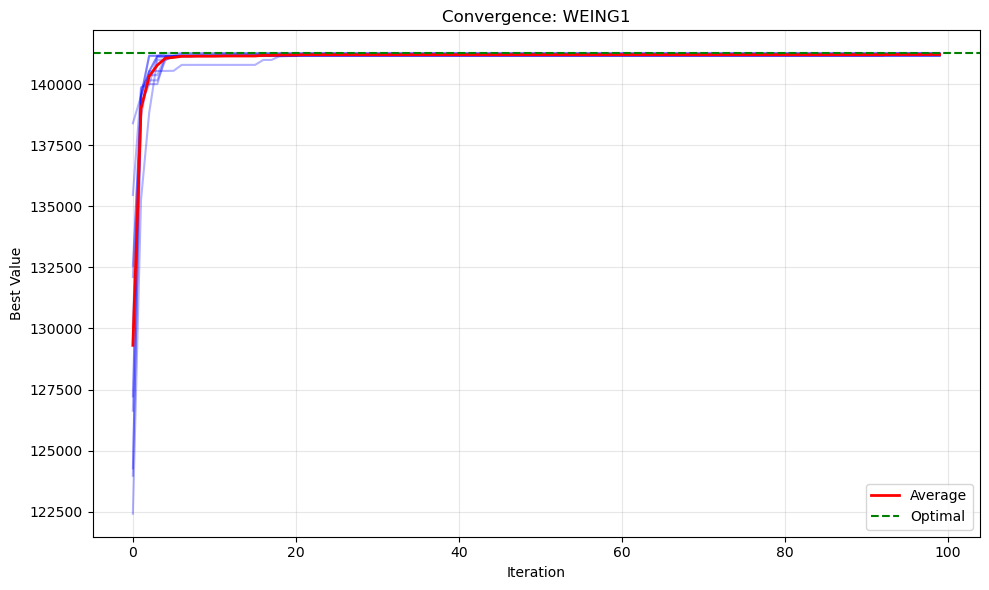

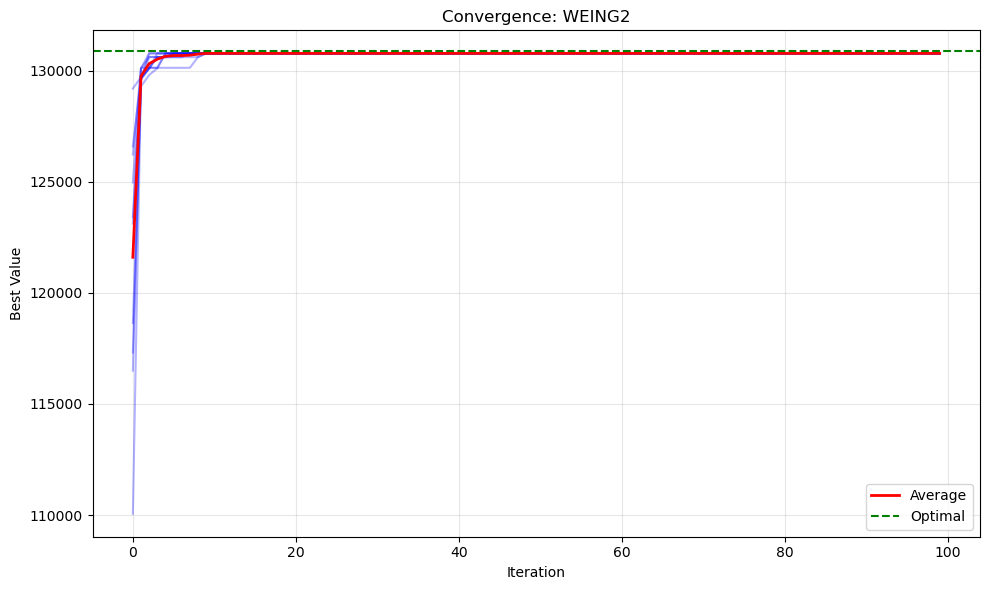

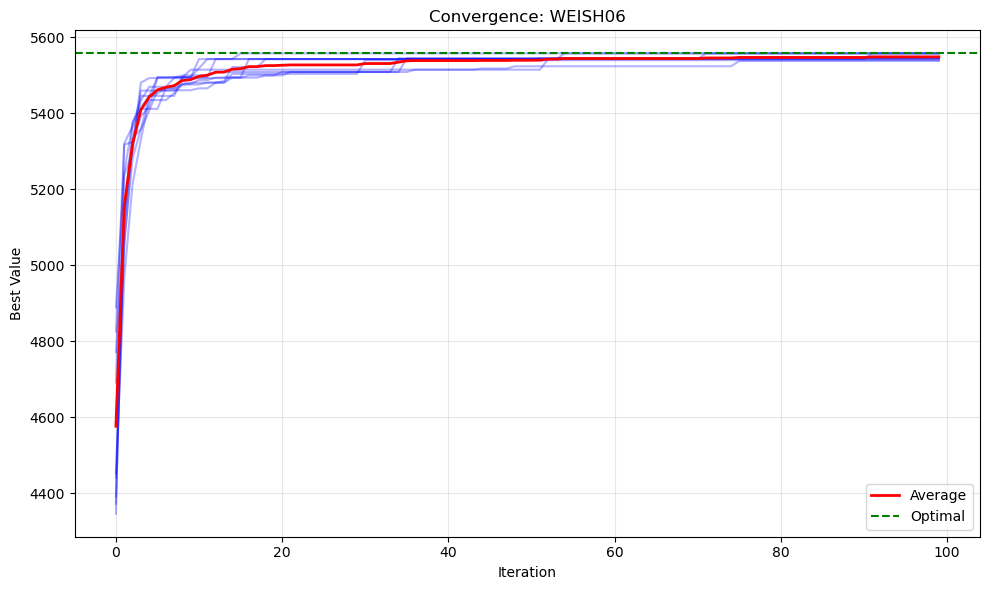

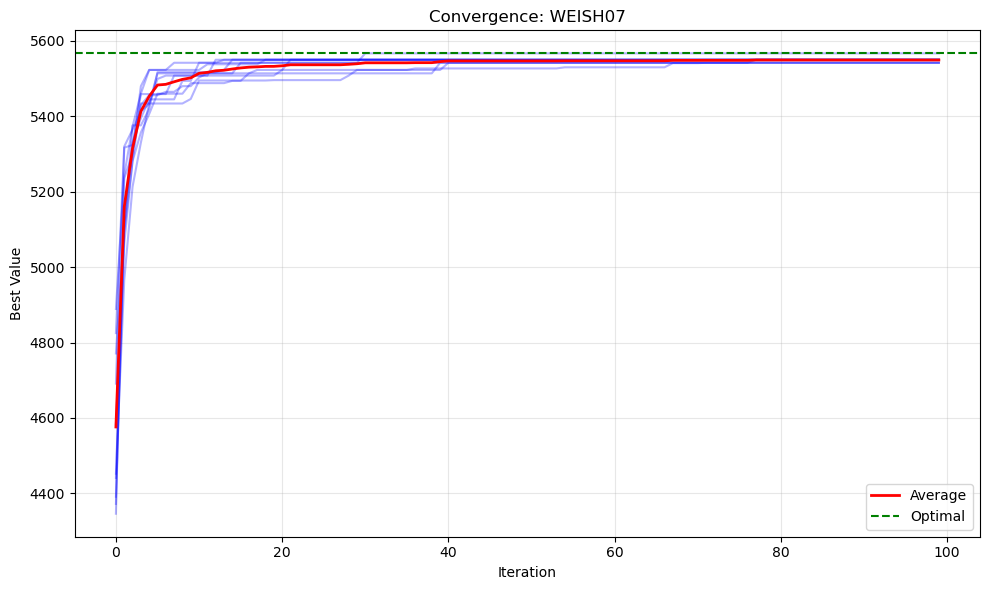

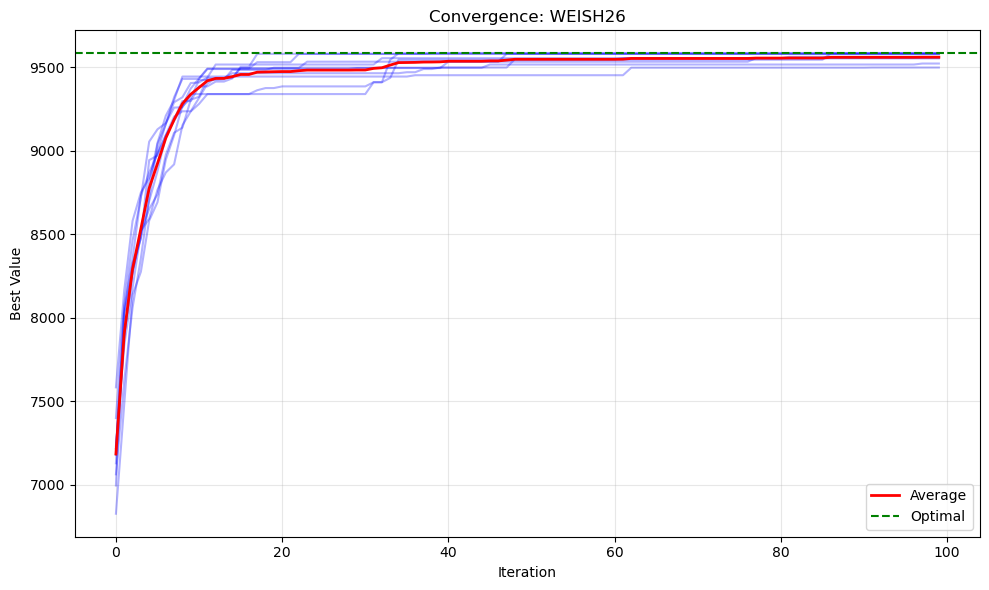

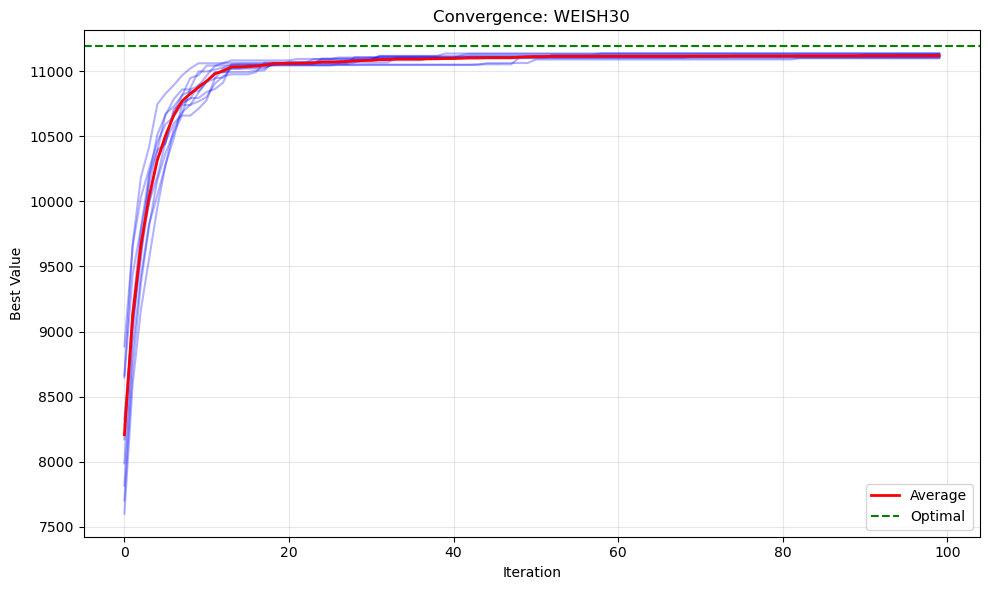

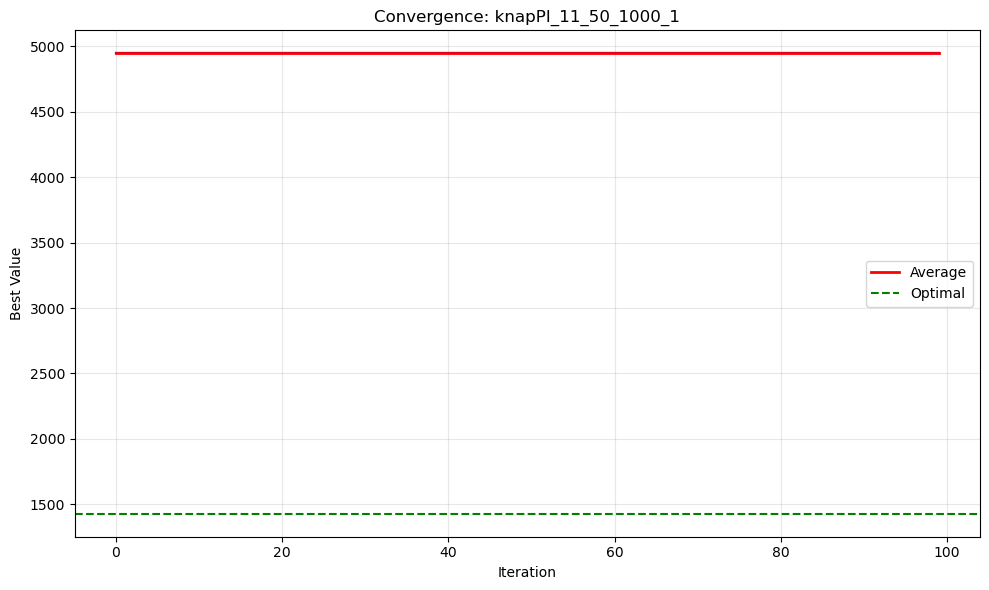


Experiments completed!


In [24]:
# ============================================================================
# MAIN EXECUTION
# ============================================================================
print("Loading instances...")

loader = DataLoader()
# Load instances
or_instances = loader.load_or_library(
    "data/OR-Library/mknap2.txt",
    ['WEING1', 'WEING2', 'WEISH06', 'WEISH07', 'WEISH26', 'WEISH30']
)
pisinger_instance = loader.load_pisinger(
    "data/PisingerHard/knapPI_11_50_1000.csv", 
    'knapPI_11_50_1000_1'
)

all_instances = or_instances + [pisinger_instance]
print(f"Loaded {len(all_instances)} instances")
for inst in all_instances:
    print(f"  - {inst.name}: {inst.num_items} items, {inst.num_knapsacks} knapsacks")

# Configure and run
ba_params = {
    'num_scout_bees': 50,
    'num_selected_sites': 10,
    'num_elite_site': 5,
    'num_bees_elite': 20,
    'num_bees_selected': 10,
    'max_iterations': 100,
    'neighborhood_size': 5
}
runner = ExperimentRunner(all_instances)
runner.run_all_instances(num_runs=10, ba_params=ba_params)

# Results
summary_df = runner.generate_summary_table()
print("\n" + "="*80)
print("SUMMARY RESULTS")
print("="*80)
print(summary_df.to_string(index=False))

# Plot convergence
for instance in all_instances:
    runner.plot_convergence(instance.name)

print("\nExperiments completed!")